In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.utils.prune as prune
from torch.utils.data.dataloader import DataLoader
import torch.utils.data as data_utils
from torch.optim import lr_scheduler
import numpy as np
from scipy import sparse as sp
import matplotlib.pyplot as plt
import sys,time
import os
import copy
import pickle

In [2]:
redDim=5

In [3]:
# Choose device that is not being used
gpu_ids = "0"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

In [4]:
def create_mask_v2(m,b,db):
    '''
    mask=create_mask_v2(m,b,db)  
    '''
    
    M2 = b + db*(m-1)
    mask = np.zeros((m,M2),dtype='int')
    
    block = np.ones(b,dtype='int')
    ind = np.arange(b)
    for row in range(m):
        col = ind + row*db
        mask[row,col] = block
    
    print(
        "Sparsity in {} by {} mask: {:.2f}%".format(
            m, M2, (1.0-np.count_nonzero(mask)/mask.size)*100
        )
    )
    
    plt.figure()
    plt.spy(mask)
    plt.show()

    return mask

In [5]:
def silu(input):
    return input * torch.sigmoid(input)
class SiLU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, input):
        return silu(input)
    
class Encoder(nn.Module):
    def __init__(self,m,M1,f):
        super(Encoder,self).__init__()
        self.full = nn.Sequential(
            nn.Linear(m,M1),
            SiLU(),
            nn.Linear(M1,f,bias=False)
        )
                
    def forward(self, y):     
        y = y.view(-1,m)
        T = self.full(y)
        T = T.squeeze()
        
        return T
    
class Decoder(nn.Module):
    def __init__(self,f,M2,m):
        super(Decoder,self).__init__()
        self.full = nn.Sequential(
            nn.Linear(f,M2,bias=False),
            SiLU(),
            nn.Linear(M2,m,bias=False)
        )
             
    def forward(self,T):
        T = T.view(-1,f)
        y = self.full(T)
        y = y.squeeze()
        
        return y

In [6]:
# load solution snapshot
solution_snapshot_orig = pickle.load(open("./data/snapshot_full.p", "rb"))
nx=1001
nt=500

# substract IC -> centered on IC
ndata=solution_snapshot_orig.shape[0]
nset= round(ndata/(nt+1))

solution_snapshot=np.array([])
for foo in range(nset):
    solution_snapshot=np.append(solution_snapshot,solution_snapshot_orig[foo*(nt+1)+1:(foo+1)*(nt+1)]\
    -solution_snapshot_orig[foo*(nt+1)])

solution_snapshot=np.reshape(solution_snapshot,(-1,nx))

# solution_snapshot_tmp1 = solution_snapshot[:501]-solution_snapshot[0]
# solution_snapshot_tmp2 = solution_snapshot[501:]-solution_snapshot[501]
# solution_snapshot = np.vstack((solution_snapshot_tmp1[1:],solution_snapshot_tmp2[1:]))

# remove BC
solution_snapshot = solution_snapshot[:,:-1].astype('float32')

# define testset and trainset indices
test_ind = np.random.permutation(np.arange(solution_snapshot.shape[0]))[:int(0.1*solution_snapshot.shape[0])]
train_ind = np.setdiff1d(np.arange(solution_snapshot.shape[0]),test_ind)

# set trainset and testset
trainset = solution_snapshot[train_ind]
testset = solution_snapshot[test_ind] 

# set dataset
dataset = {'train':data_utils.TensorDataset(torch.tensor(trainset)),
           'test':data_utils.TensorDataset(torch.tensor(testset))}
print(dataset['train'].tensors[0].shape, dataset['test'].tensors[0].shape)

torch.Size([900, 1000]) torch.Size([100, 1000])


In [7]:
# compute dataset shapes
dataset_shapes = {'train':trainset.shape,
                 'test':testset.shape}

print(dataset_shapes['train'],dataset_shapes['test'])

(900, 1000) (100, 1000)


In [8]:
# set batch_size, number of epochs, paitience for early stop
batch_size = 20
num_epochs = 10000
num_epochs_print = num_epochs//100
early_stop_patience = num_epochs//50

In [9]:
# set data loaders
train_loader = DataLoader(dataset=dataset['train'], 
                          batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(dataset=dataset['test'], 
                         batch_size=batch_size, shuffle=True, num_workers=0)

data_loaders = {'train':train_loader, 'test':test_loader}

In [11]:
# set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, '\n')

Using device: cpu 



In [14]:
# set checkpoint
PATH = './checkpoint_v2_red-dim_{}.tar'.format(redDim)

# set file name for AE
file_name_AE_pkl="./model/AE_v2_swish_red-dim_{}.pkl".format(redDim)
file_name_AE="./model/AE_v2_swish_red-dim_{}.p".format(redDim)

In [15]:
# set the number of nodes in each layer
m = 1000
f = redDim
b = 36
db = 12
M2 = b + (m-1)*db
M1 = 2*m

Sparsity in 1000 by 12024 mask: 99.70%


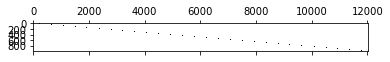


--------checkpoint not restored--------

Sparsity in 1000 by 12024 mask: 99.70%

Start first training... m=1000, f=5, M1=2000, M2=12024, b=36, db=12


In [16]:
# load model
try:
    checkpoint = torch.load(PATH, map_location=device)
    
    encoder = Encoder(m,M1,f).to(device)
    decoder = Decoder(f,M2,m).to(device)
    
    # Prune
    mask = create_mask_v2(m,b,db)
    prune.custom_from_mask(decoder.full[2], name='weight', mask=torch.tensor(mask).to(device))    
    
#     optimizer = torch.optim.LBFGS(list(encoder.parameters()) + list(decoder.parameters()), lr=1)
#     scheduler = None     
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=10) 
    
    loss_func = nn.MSELoss(reduction='mean')
    
    encoder.load_state_dict(checkpoint['encoder_state_dict'])
    decoder.load_state_dict(checkpoint['decoder_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    last_epoch = checkpoint['epoch']
    loss_hist = checkpoint['loss_hist']
    best_loss = checkpoint['best_loss']
    early_stop_counter = checkpoint['early_stop_counter']
    best_encoder_wts = checkpoint['best_encoder_wts']
    best_decoder_wts = checkpoint['best_decoder_wts']
    
    print("\n--------checkpoint restored--------\n")
    
    # compute sparsity in mask
    mask = decoder.state_dict()['full.2.weight_mask']
    print("Sparsity in {} by {} mask: {:.2f}%".format(
        mask.shape[0], mask.shape[1], 100. * float(torch.sum(mask == 0))/ float(mask.nelement())))

    # resume training
    print("")
    print('Re-start {}th training... m={}, f={}, M1={}, M2={}, b={}, db={}'.format(
        last_epoch+1, m, f, M1, M2, b, db))
except:
    encoder = Encoder(m,M1,f).to(device)
    decoder = Decoder(f,M2,m).to(device)
    
    # Prune
    mask = create_mask_v2(m,b,db)
    prune.custom_from_mask(decoder.full[2], name='weight', mask=torch.tensor(mask).to(device))

#     optimizer = torch.optim.LBFGS(list(encoder.parameters()) + list(decoder.parameters()), lr=1)
#     scheduler = None 
    optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=0.001)
    scheduler = lr_scheduler.ReduceLROnPlateau(optimizer,patience=10) 
    
    loss_func = nn.MSELoss(reduction='mean')
    
    last_epoch = 0
    loss_hist = {'train':[],'test':[]}
    best_loss = float("inf")
    early_stop_counter = 1
    best_encoder_wts = copy.deepcopy(encoder.state_dict())
    best_decoder_wts = copy.deepcopy(decoder.state_dict())
    
    print("\n--------checkpoint not restored--------\n")
    
    # compute sparsity in mask
    mask = decoder.state_dict()['full.2.weight_mask']
    print("Sparsity in {} by {} mask: {:.2f}%".format(
        mask.shape[0], mask.shape[1], 100. * float(torch.sum(mask == 0))/ float(mask.nelement())))

    # start training
    print("")
    print('Start first training... m={}, f={}, M1={}, M2={}, b={}, db={}'.format(
        m, f, M1, M2, b, db))
pass

In [17]:
# train model
since = time.time()

for epoch in range(last_epoch+1,num_epochs+1):   

    if epoch%num_epochs_print == 0:
        print()
        if scheduler !=None:
            print('Epoch {}/{}, Learning rate {}'.format(
                epoch, num_epochs, optimizer.state_dict()['param_groups'][0]['lr']))
        else:
            print('Epoch {}/{}'.format(
                epoch, num_epochs))
        print('-' * 10)

    # Each epoch has a training and test phase
    for phase in ['train', 'test']:
        if phase == 'train':
            encoder.train()  # Set model to training mode
            decoder.train()  # Set model to training mode
        else:
            encoder.eval()   # Set model to evaluation mode
            decoder.eval()   # Set model to evaluation mode
            
        running_loss = 0.0

        # Iterate over data
        for data, in data_loaders[phase]:
            inputs = data.to(device)
            targets = data.to(device)

            if phase == 'train':
                if scheduler != None:
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    outputs = decoder(encoder(inputs))
                    loss = loss_func(outputs, targets)

                    # backward
                    loss.backward()

                    # optimize
                    optimizer.step()  
                    
                    # add running loss
                    running_loss += loss.item()*inputs.shape[0]
                else:
                    def closure():
                        # zero the parameter gradients
                        optimizer.zero_grad()

                        # forward
                        outputs = decoder(encoder(inputs))
                        loss = loss_func(outputs,targets)

                        # backward
                        loss.backward()
                        return loss

                    # optimize
                    optimizer.step(closure)
                    
                    # add running loss
                    with torch.set_grad_enabled(False):
                        outputs = decoder(encoder(inputs))
                        running_loss += loss_func(outputs,targets).item()*inputs.shape[0]
                    
            else:
                with torch.set_grad_enabled(False):
                    outputs = decoder(encoder(inputs))
                    running_loss += loss_func(outputs,targets).item()*inputs.shape[0]

        # compute epoch loss
        epoch_loss = running_loss / dataset_shapes[phase][0]
        loss_hist[phase].append(epoch_loss)
            
        # update learning rate
        if phase == 'train' and scheduler != None:
            scheduler.step(epoch_loss)

        if epoch%num_epochs_print == 0:
            print('{} MSELoss: {}'.format(
                phase, epoch_loss))

    # deep copy the model
    if loss_hist['test'][-1] < best_loss:
        best_loss = loss_hist['test'][-1]
        early_stop_counter = 1
        best_encoder_wts = copy.deepcopy(encoder.state_dict())
        best_decoder_wts = copy.deepcopy(decoder.state_dict())
    else:
        early_stop_counter += 1
        if early_stop_counter >= early_stop_patience:  
            break
    
    # save checkpoint every num_epoch_print
    if epoch%num_epochs_print== 0:
        torch.save({
                    'epoch': epoch,
                    'encoder_state_dict': encoder.state_dict(),
                    'decoder_state_dict': decoder.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'loss_hist': loss_hist,
                    'best_loss': best_loss,
                    'early_stop_counter': early_stop_counter,
                    'best_encoder_wts': best_encoder_wts,
                    'best_decoder_wts': best_decoder_wts,
                    }, PATH)        

print()
print('Epoch {}/{}, Learning rate {}'\
      .format(epoch, num_epochs, optimizer.state_dict()['param_groups'][0]['lr']))
print('-' * 10)
print('train MSELoss: {}'.format(loss_hist['train'][-1]))
print('test MSELoss: {}'.format(loss_hist['test'][-1]))

time_elapsed = time.time() - since

# load best model weights
encoder.load_state_dict(best_encoder_wts)
decoder.load_state_dict(best_decoder_wts)

# compute best train MSELoss
encoder.to('cpu').eval()
decoder.to('cpu').eval()

with torch.set_grad_enabled(False):
    train_inputs = torch.tensor(trainset)
    train_targets = torch.tensor(trainset)
    train_outputs = decoder(encoder(train_inputs))
    train_loss = loss_func(train_outputs,train_targets).item()

# print out training time and best results
print()
if epoch < num_epochs:
    print('Early stopping: {}th training complete in {:.0f}h {:.0f}m {:.0f}s'\
          .format(epoch-last_epoch, time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
else:
    print('No early stopping: {}th training complete in {:.0f}h {:.0f}m {:.0f}s'\
          .format(epoch-last_epoch, time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
print('-' * 10)
print('Best train MSELoss: {}'.format(train_loss))
print('Best test MSELoss: {}'.format(best_loss))

# # save models
# print()
# print("Saving after {}th training to".format(epoch),
#       file_name_AE_pkl)
# torch.save((encoder,decoder),file_name_AE_pkl) 


Epoch 100/10000, Learning rate 0.0001
----------
train MSELoss: 1.944950284572163e-05
test MSELoss: 1.625546374270925e-05

Epoch 200/10000, Learning rate 1e-05
----------
train MSELoss: 1.0164280471750923e-05
test MSELoss: 8.513390366715611e-06

Epoch 300/10000, Learning rate 1e-05
----------
train MSELoss: 9.389184267800172e-06
test MSELoss: 7.744236427242868e-06

Epoch 400/10000, Learning rate 1e-05
----------
train MSELoss: 8.52496418196501e-06
test MSELoss: 7.036532224447001e-06

Epoch 500/10000, Learning rate 1e-05
----------
train MSELoss: 7.832397512983233e-06
test MSELoss: 6.591223245777655e-06

Epoch 600/10000, Learning rate 1e-05
----------
train MSELoss: 7.217044973610124e-06
test MSELoss: 5.979144498269307e-06

Epoch 700/10000, Learning rate 1e-05
----------
train MSELoss: 6.687533975006469e-06
test MSELoss: 5.630117175314808e-06

Epoch 800/10000, Learning rate 1e-05
----------
train MSELoss: 6.229210440425151e-06
test MSELoss: 5.1900377911806576e-06

Epoch 900/10000, Lear

In [18]:
# delete checkpoint
try:
    os.remove(PATH)
    print()
    print("checkpoint removed")
except:
    print("no checkpoint exists")


checkpoint removed


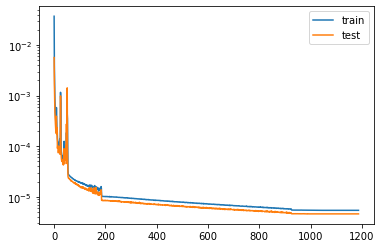

In [19]:
# plot train and test loss
plt.figure()
plt.semilogy(loss_hist['train'])
plt.semilogy(loss_hist['test'])
plt.legend(['train','test'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()   

pickle.dump(loss_hist,open('./data/loss_hist_v2_swish_red-dim_{}.p'.format(redDim),'wb'))

In [20]:
# release gpu memory
torch.cuda.empty_cache()